In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Report **

**1. Types of Approach**

Convolutional Neural Networks (CNNs): Utilize architectures such as ResNet, EfficientNet, VGG, etc.

Transfer Learning: Leverage pre-trained models (e.g., on ImageNet) and fine-tune them for bird identification.

Data Augmentation: Employ various augmentation techniques to increase data diversity.

Ensemble Methods: Combine predictions from multiple models for improved accuracy.

Feature Extraction vs. Fine-tuning: Experiment with freezing lower layers and fine-tuning higher layers.

**2 Performance Improvement Techniques (Ordered from Best to Least Improvement):**

**Data Augmentation**: Extensive augmentation to improve the model’s generalization ability.

**Transfer Learning & Fine-tuning:** Leverage pre-trained models and fine-tune key layers for your specific task.

**Changing Model**: Experiment with different network architectures (e.g., EfficientNet, DenseNet) to find the best fit for bird identification.

**Hyperparameter Tuning**: Optimize learning rates, batch sizes, and other optimizer parameters.

**Regularization Techniques:** Apply dropout, weight decay, and early stopping to prevent overfitting.

**Ensemble Methods:** Combine multiple models’ predictions to further boost performance.

In [ ]:
import shutil
import os

# **Original dataset path**
source_path = "/content/CUB_200_2011"  # Make sure this path is correct

# **Target storage path**
target_path = "/content/drive/MyDrive/CUB_200_2011"  # The path where you want to store the data

# **Check if Google Drive is mounted**
if not os.path.exists("/content/drive/MyDrive"):
    from google.colab import drive
    drive.mount('/content/drive')

# **Perform copying**
if not os.path.exists(target_path):
    print(f"Copying dataset to {target_path} ...")
    shutil.copytree(source_path, target_path)  # Recursively copy the entire folder
    print("✅ Dataset copied successfully!")
else:
    print("⚠️ Dataset already exists in MyDrive!")


⚠️ Dataset already exists in MyDrive!


In [5]:
import os
import shutil
import random
from zipfile import ZipFile
from tqdm import tqdm  # Display progress bar

# **Step 1: Unzip the dataset**
zip_path = "/content/drive/MyDrive/bird_CUB_200_2011.zip"  # Modify this to your actual path
extract_path = "/content/CUB_200_2011"

# Check if the dataset has already been extracted to avoid redundant extraction
if not os.path.exists(extract_path):
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content")

# **Step 2: Set up dataset directories**
data_root = extract_path  # Root directory of the dataset
images_dir = os.path.join(data_root, "images")  # Directory for original images
train_dir = os.path.join(data_root, "train_images")  # Directory for the training set
test_dir = os.path.join(data_root, "test_images")  # Directory for the test set

# Ensure that the target directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# **Step 3: Read dataset auxiliary files**
def read_file(file_path):
    """Read a data file and split it by lines"""
    with open(file_path, "r") as f:
        return [line.strip().split() for line in f.readlines()]

# Parse the files provided with the dataset
image_list = read_file(os.path.join(data_root, "images.txt"))  # List of image paths
image_labels = read_file(os.path.join(data_root, "image_class_labels.txt"))  # Mapping from image IDs to class IDs
train_test_split = read_file(os.path.join(data_root, "train_test_split.txt"))  # Train/test split information
classes = read_file(os.path.join(data_root, "classes.txt"))  # Mapping from class IDs to class names

# **Step 4: Build class mapping**
class_map = {c[0]: c[1] for c in classes}  # {class ID: class name}
image_class_map = {img[0]: img[1] for img in image_labels}  # {image ID: class ID}
image_split_map = {split[0]: split[1] for split in train_test_split}  # {image ID: 0 (test) or 1 (train)}

# **Step 5: Organize the data**
print("📂 Organizing dataset...")

# Iterate over all images in the dataset
for img_id, img_path in tqdm(image_list, desc="Processing Images"):
    label_id = image_class_map[img_id]  # Get the class ID
    split_flag = image_split_map[img_id]  # Get the train/test flag

    # Determine the target directory (train or test)
    target_root = train_dir if split_flag == "1" else test_dir
    class_name = class_map[label_id]  # Get the class name
    target_class_dir = os.path.join(target_root, class_name)

    # Create the directory for the class if it does not exist
    os.makedirs(target_class_dir, exist_ok=True)

    # Construct the source file path and destination file path
    src_path = os.path.join(images_dir, img_path)  # Original path
    dest_path = os.path.join(target_class_dir, os.path.basename(img_path))  # Destination path

    # Move the file; if moving fails, copy it instead
    if os.path.exists(src_path):  # Ensure the file exists
        try:
            shutil.move(src_path, dest_path)  # Move the file directly
        except Exception as e:
            shutil.copy(src_path, dest_path)  # If moving fails, copy the file
            os.remove(src_path)  # Remove the original file

print("✅ Dataset organization completed!")

# **Step 6: Split the training set (9:1)**
print("📂 Splitting training set into training and validation subsets...")

# Set up target directories for the training subset and validation subset
train_subset_dir = os.path.join(data_root, "train_subset")
val_subset_dir = os.path.join(data_root, "val_subset")

# Ensure that the target directories exist
os.makedirs(train_subset_dir, exist_ok=True)
os.makedirs(val_subset_dir, exist_ok=True)

# Iterate over all classes in the training set
for class_name in tqdm(os.listdir(train_dir), desc="Splitting Train Set"):
    class_train_dir = os.path.join(train_dir, class_name)  # Original training set directory for the class
    class_train_subset_dir = os.path.join(train_subset_dir, class_name)  # Directory for the training subset for the class
    class_val_subset_dir = os.path.join(val_subset_dir, class_name)  # Directory for the validation subset for the class

    # Create directories for the training and validation subsets for the class
    os.makedirs(class_train_subset_dir, exist_ok=True)
    os.makedirs(class_val_subset_dir, exist_ok=True)

    # Get all image files for this class
    images = os.listdir(class_train_dir)
    if len(images) == 0:
        continue  # Skip to avoid errors due to empty directories

    random.shuffle(images)  # Shuffle the images randomly to avoid order bias affecting the model

    # Calculate the split index for a 9:1 division
    split_idx = int(len(images) * 0.9)
    train_images = images[:split_idx]
    val_images = images[split_idx:]

    # Move files to the corresponding subdirectories
    for img in train_images:
        shutil.move(os.path.join(class_train_dir, img), os.path.join(class_train_subset_dir, img))

    for img in val_images:
        shutil.move(os.path.join(class_train_dir, img), os.path.join(class_val_subset_dir, img))

print("✅ Training set has been split into training and validation subsets!")


📂 Organizing dataset...


Processing Images: 100%|██████████| 11788/11788 [00:00<00:00, 27487.99it/s]


✅ Dataset organization completed!
📂 Splitting training set into training and validation subsets...


Splitting Train Set: 100%|██████████| 200/200 [00:00<00:00, 1341.94it/s]

✅ Training set has been split into training and validation subsets!


In [6]:
# Method 1: Load pre-trained EfficientNet-B5 model
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Set data directory paths
data_root = "./CUB_200_2011"
train_dir = os.path.join(data_root, "train_subset")
val_dir = os.path.join(data_root, "val_subset")
test_dir = os.path.join(data_root, "test_images")

# **Step 1: Define data augmentation (Data Augmentation)**
# train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),  # Random cropping
#     transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
#     transforms.RandomRotation(20),  # Rotate ±20°
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),  # Color jitter
#
#     transforms.ToTensor(),  # **Convert to Tensor (must be before RandomErasing)**
#     transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Random erasing
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
# ])

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Perspective transform
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# **Step 2: Define transforms for validation and testing data (usually no augmentation needed)**
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# **Step 3: Load the dataset**
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)

# **Step 4: Create DataLoaders**
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# **Step 5: Print class mapping (optional)**
class_names = train_dataset.classes
print(f"Data categories: {class_names}")
print(f"Training set samples: {len(train_dataset)}, Validation set samples: {len(val_dataset)}, Test set samples: {len(test_dataset)}")

# **Step 6: Test the DataLoader**
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Batch size: {images.shape}")  # (batch_size, 3, 224, 224)


Data categories: ['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird', '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink', '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '020.Yellow_breasted_Chat', '021.Eastern_Towhee', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '025.Pelagic_Cormorant', '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo', '034.Gray_crowned_Rosy_Finch', '035.Purple_Finch', '036.Northern_Flicker', '037.Acadian_Flycatcher', '038.Great_Crested_Flycatcher', '039.Least_Flycatcher', '040.Olive_sided_Flycatcher', '041.Scissor_tailed_Flyc

In [7]:
# Load pre-trained EfficientNet-B5 model
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import os

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Step 1: Load the pre-trained EfficientNet-B5 model**
model = models.efficientnet_b5(weights=models.EfficientNet_B5_Weights.DEFAULT)

# **Step 2: Modify the classification layer to ensure Dropout is effective**
num_ftrs = model.classifier[1].in_features  # Get the number of input features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # 50% dropout to prevent overfitting
    nn.Linear(num_ftrs, len(train_dataset.classes))  # Output number equals the number of classes
)

# Move the model to GPU (if available)
model = model.to(device)

# **Step 3: Set up the loss function and optimizer**
criterion = nn.CrossEntropyLoss()

# Use stronger L2 regularization
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

# Cosine annealing learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)


# **Step 4: Define the training function**
def train_model(model, train_loader, val_loader, num_epochs=50, patience=5):
    best_val_loss = np.inf
    epochs_no_improve = 0
    best_model_path = "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100. * correct / total

        # **Step 5: Evaluate the model**
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= total
        val_acc = 100. * correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # **Step 6: Early stopping mechanism**
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)  # Save the best model
            print(f"🔹 Best model saved at epoch {epoch+1} with Val Loss: {val_loss:.4f}")
        else:
            epochs_no_improve += 1
            print(f"⚠️ No improvement for {epochs_no_improve} epochs...")

        if epochs_no_improve >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}!")
            break

        scheduler.step()  # Update the learning rate

    print("🎉 Training complete!")

# **Step 7: Train the model**
# train_model(model, train_loader, val_loader, num_epochs=50, patience=5)
train_model(model, train_loader, val_loader, num_epochs=50, patience=5)


Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 202MB/s]


Epoch [1/50] - Train Loss: 5.2632, Train Acc: 1.26% | Val Loss: 5.0954, Val Acc: 8.50%
🔹 Best model saved at epoch 1 with Val Loss: 5.0954
Epoch [2/50] - Train Loss: 4.7742, Train Acc: 9.96% | Val Loss: 3.9287, Val Acc: 20.67%
🔹 Best model saved at epoch 2 with Val Loss: 3.9287
Epoch [3/50] - Train Loss: 3.8387, Train Acc: 21.30% | Val Loss: 3.0263, Val Acc: 38.33%
🔹 Best model saved at epoch 3 with Val Loss: 3.0263
Epoch [4/50] - Train Loss: 3.0967, Train Acc: 34.89% | Val Loss: 2.4643, Val Acc: 49.00%
🔹 Best model saved at epoch 4 with Val Loss: 2.4643
Epoch [5/50] - Train Loss: 2.6053, Train Acc: 44.05% | Val Loss: 2.0999, Val Acc: 55.33%
🔹 Best model saved at epoch 5 with Val Loss: 2.0999
Epoch [6/50] - Train Loss: 2.2445, Train Acc: 51.93% | Val Loss: 1.8217, Val Acc: 62.00%
🔹 Best model saved at epoch 6 with Val Loss: 1.8217
Epoch [7/50] - Train Loss: 2.0012, Train Acc: 56.97% | Val Loss: 1.6908, Val Acc: 63.67%
🔹 Best model saved at epoch 7 with Val Loss: 1.6908
Epoch [8/50] - T

In [8]:
model.load_state_dict(torch.load("best_model.pth"))

<ipython-input-8-4e55fec23aa2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

In [9]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = 100. * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 75.87%


✅ Test Accuracy: 75.87%
✅ Test Precision: 76.25%
✅ Test Recall: 75.96%
✅ Test F1-score: 75.63%

🔹 Classification Report:

                                    precision    recall  f1-score   support

        001.Black_footed_Albatross     0.7500    0.7000    0.7241        30
              002.Laysan_Albatross     0.7568    0.9333    0.8358        30
               003.Sooty_Albatross     0.6970    0.8214    0.7541        28
             004.Groove_billed_Ani     0.7742    0.8000    0.7869        30
                005.Crested_Auklet     0.6316    0.8571    0.7273        14
                  006.Least_Auklet     0.8182    0.8182    0.8182        11
               007.Parakeet_Auklet     0.9048    0.8261    0.8636        23
             008.Rhinoceros_Auklet     0.8125    0.7222    0.7647        18
              009.Brewer_Blackbird     0.4783    0.3793    0.4231        29
          010.Red_winged_Blackbird     0.8750    0.9333    0.9032        30
               011.Rusty_Blackbird     0.

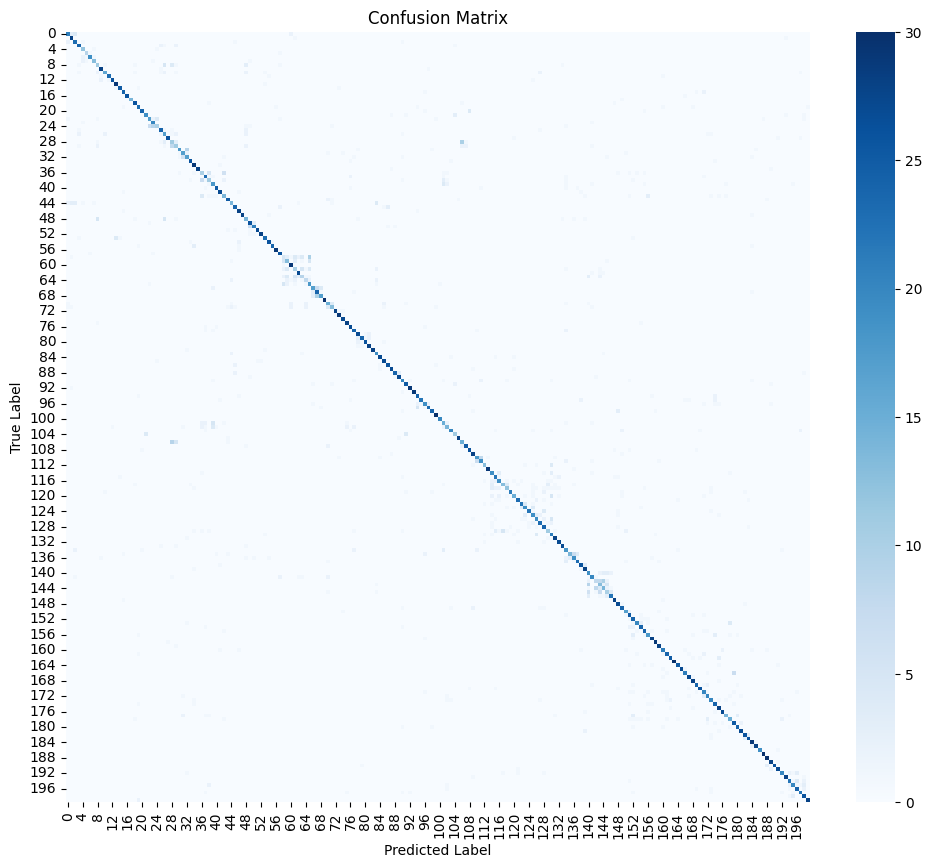

In [10]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# **Step 1: Compute Accuracy, Precision, Recall, and F1-score**
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# **Convert to NumPy arrays**
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# **Calculate metrics**
test_accuracy = accuracy_score(all_labels, all_preds) * 100
test_precision = precision_score(all_labels, all_preds, average='macro') * 100
test_recall = recall_score(all_labels, all_preds, average='macro') * 100
test_f1 = f1_score(all_labels, all_preds, average='macro') * 100

# **Print metrics**
print(f"✅ Test Accuracy: {test_accuracy:.2f}%")
print(f"✅ Test Precision: {test_precision:.2f}%")
print(f"✅ Test Recall: {test_recall:.2f}%")
print(f"✅ Test F1-score: {test_f1:.2f}%")

# **Step 2: Generate Classification Report**
print("\n🔹 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes, digits=4))

# **Step 3: Plot Confusion Matrix**
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Image: /content/drive/MyDrive/CUB_200_2011/test_images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg -> Predicted class: 001.Black_footed_Albatross


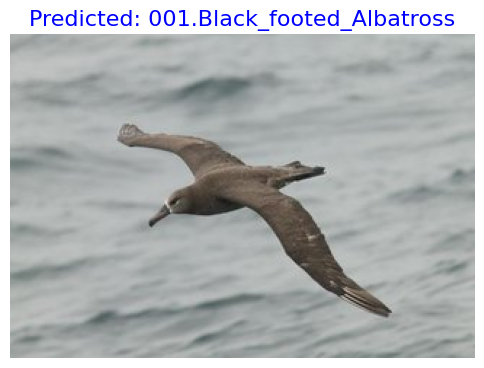

Image: /content/drive/MyDrive/CUB_200_2011/test_images/003.Sooty_Albatross/Sooty_Albatross_0002_796395.jpg -> Predicted class: 003.Sooty_Albatross


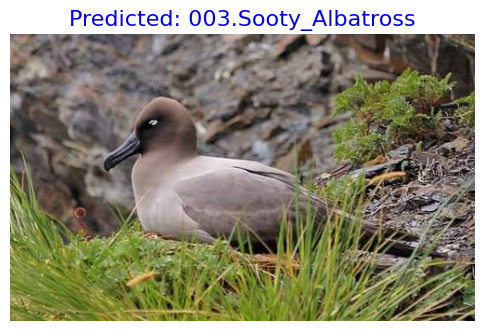

In [14]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def predict_image(image_path, model, device):
    """
    Predict the class of an image using the given model.

    Args:
        image_path (str): Path to the image.
        model (torch.nn.Module): Trained model.
        device (torch.device): Device to run the model on.

    Returns:
        int: Predicted class index.
        PIL.Image: The original image (for display purposes).
    """
    # Define the transform (same as for validation/testing)
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Open the image and apply the transformations
    image = Image.open(image_path).convert('RGB')
    transformed_image = test_transform(image)
    transformed_image = transformed_image.unsqueeze(0)  # Add batch dimension

    # Move image to device
    transformed_image = transformed_image.to(device)

    # Set the model to evaluation mode and make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(transformed_image)
        _, predicted = outputs.max(1)

    return predicted.item(), image  # Return both the prediction and the original image

# Example usage:
# List of image paths you want to test
test_image_paths = [
    "/content/drive/MyDrive/CUB_200_2011/test_images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg",
    "/content/drive/MyDrive/CUB_200_2011/test_images/003.Sooty_Albatross/Sooty_Albatross_0002_796395.jpg"
]

# Loop through the images, predict the class, and display the image.
for img_path in test_image_paths:
    pred_class, orig_image = predict_image(img_path, model, device)
    # Assuming train_dataset.classes holds the mapping from class index to class name
    predicted_label = train_dataset.classes[pred_class]
    print(f"Image: {img_path} -> Predicted class: {predicted_label}")

    # Display the image with the prediction as title
    plt.figure(figsize=(6, 6))
    plt.imshow(orig_image)
    plt.title(f"Predicted: {predicted_label}", fontsize=16, color='blue')
    plt.axis('off')
    plt.show()


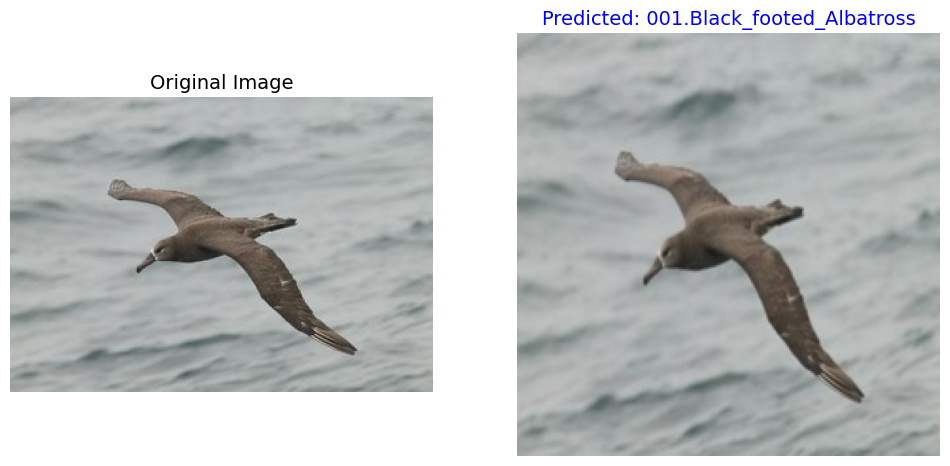

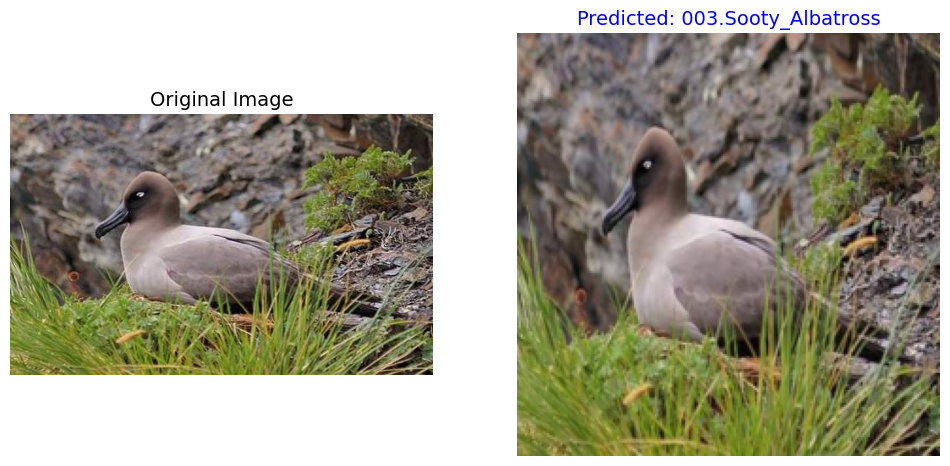

In [16]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def unnormalize(tensor, mean, std):
    """
    Unnormalize function: restores a normalized tensor to the original image data.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def predict_and_display(image_path, model, device, class_names):
    """
    Predict the class of an image and display both the original image and the preprocessed image (with prediction result).

    Args:
        image_path (str): Path to the image.
        model (torch.nn.Module): Trained model.
        device (torch.device): Device to run the model on (GPU or CPU).
        class_names (list): List of class names for mapping the predicted index to a class name.
    """
    # Define the same preprocessing pipeline as used for validation/testing
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the image to 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Load the original image
    original_image = Image.open(image_path).convert('RGB')

    # Preprocess the image
    transformed_image = test_transform(original_image)
    input_tensor = transformed_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Model prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = outputs.max(1)
    pred_label = class_names[predicted.item()]

    # Unnormalize the preprocessed image for display
    unnorm_tensor = transformed_image.clone()
    unnorm_tensor = unnormalize(unnorm_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    unnorm_image = transforms.ToPILImage()(unnorm_tensor)

    # Use Matplotlib to display both the original image and the unnormalized preprocessed image (with prediction title)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original_image)
    axes[0].set_title("Original Image", fontsize=14)
    axes[0].axis("off")

    axes[1].imshow(unnorm_image)
    axes[1].set_title(f"Predicted: {pred_label}", fontsize=14, color='blue')
    axes[1].axis("off")

    plt.show()

# Example: list of test image paths (replace with your own image paths)
test_image_paths = [
    "/content/drive/MyDrive/CUB_200_2011/test_images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg",
    "/content/drive/MyDrive/CUB_200_2011/test_images/003.Sooty_Albatross/Sooty_Albatross_0002_796395.jpg"
]

# Iterate through test images, predict the class, and display them
for img_path in test_image_paths:
    predict_and_display(img_path, model, device, train_dataset.classes)


In [12]:
import torch
from PIL import Image
import torchvision.transforms as transforms

def predict_image(image_path, model, device):
    """
    Predict the class of an image using the given model.

    Args:
        image_path (str): Path to the image.
        model (torch.nn.Module): Trained model.
        device (torch.device): Device to run the model on.

    Returns:
        int: Predicted class index.
    """
    # Define the transform (same as for validation/testing)
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Open the image and apply the transformations
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image)
    image = image.unsqueeze(0)  # Add batch dimension

    # Move image to device
    image = image.to(device)

    # Set the model to evaluation mode and make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = outputs.max(1)

    return predicted.item()

# Example usage:
# List of image paths you want to test
test_image_paths = ["/content/drive/MyDrive/CUB_200_2011/test_images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg", "/content/drive/MyDrive/CUB_200_2011/test_images/003.Sooty_Albatross/Sooty_Albatross_0002_796395.jpg"]

# Loop through the images, predict the class, and print the result.
for img_path in test_image_paths:
    pred_class = predict_image(img_path, model, device)
    # Assuming train_dataset.classes holds the mapping from class index to class name
    print(f"Image: {img_path} -> Predicted class: {train_dataset.classes[pred_class]}")


Image: /content/drive/MyDrive/CUB_200_2011/test_images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg -> Predicted class: 001.Black_footed_Albatross
Image: /content/drive/MyDrive/CUB_200_2011/test_images/003.Sooty_Albatross/Sooty_Albatross_0002_796395.jpg -> Predicted class: 003.Sooty_Albatross


In [ ]:
# Method 2: ResNet-101 方法2 ResNet-101

In [ ]:
# Dataset Partitioning
import os
import shutil
import random
from zipfile import ZipFile
from tqdm import tqdm  # Display progress bar

# **Step 1: Unzip the dataset**
zip_path = "/content/drive/MyDrive/bird_CUB_200_2011.zip"  # Modify this to your actual path
extract_path = "/content/CUB_200_2011"

if not os.path.exists(extract_path):  # Avoid duplicate extraction
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content")

# **Step 2: Set up dataset directories**
data_root = extract_path
images_dir = os.path.join(data_root, "images")  # Directory for original images
train_dir = os.path.join(data_root, "train_images")
test_dir = os.path.join(data_root, "test_images")

# **Step 3: Read dataset auxiliary files**
def read_file(file_path):
    """Read the data file and parse it into a dictionary"""
    return {line.split()[0]: line.split()[1] for line in open(file_path, "r")}

image_labels = read_file(os.path.join(data_root, "image_class_labels.txt"))  # {Image ID: Class ID}
image_split = read_file(os.path.join(data_root, "train_test_split.txt"))  # {Image ID: 0/1 (Test/Train)}
class_map = read_file(os.path.join(data_root, "classes.txt"))  # {Class ID: Class Name}

# **Step 4: Organize the dataset**
print("📂 Organizing dataset...")

for img_id, img_path in tqdm(read_file(os.path.join(data_root, "images.txt")).items(), desc="Processing Images"):
    class_name = class_map[image_labels[img_id]]  # Get the class name
    target_root = train_dir if image_split[img_id] == "1" else test_dir  # Training or testing

    target_class_dir = os.path.join(target_root, class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    src_path = os.path.join(images_dir, img_path)
    dest_path = os.path.join(target_class_dir, os.path.basename(img_path))

    if os.path.exists(src_path):
        shutil.move(src_path, dest_path)  # Directly move to avoid redundant try-except code

print("✅ Dataset organization completed!")

# **Step 5: Split training set (9:1)**
print("📂 Splitting training set into training and validation subsets...")

train_subset_dir = os.path.join(data_root, "train_subset")
val_subset_dir = os.path.join(data_root, "val_subset")

for root_dir in [train_subset_dir, val_subset_dir]:
    os.makedirs(root_dir, exist_ok=True)

for class_name in tqdm(os.listdir(train_dir), desc="Splitting Train Set"):
    class_path = os.path.join(train_dir, class_name)
    images = os.listdir(class_path)

    if not images:
        continue  # Ignore empty classes

    random.shuffle(images)
    split_idx = int(len(images) * 0.9)

    for subset, img_list in zip([train_subset_dir, val_subset_dir], [images[:split_idx], images[split_idx:]]):
        target_class_dir = os.path.join(subset, class_name)
        os.makedirs(target_class_dir, exist_ok=True)

        for img in img_list:
            shutil.move(os.path.join(class_path, img), os.path.join(target_class_dir, img))

print("✅ Training set has been split into training and validation subsets!")



📂 Organizing dataset...


Processing Images: 100%|██████████| 11788/11788 [00:00<00:00, 26412.71it/s]


✅ Dataset organization completed!
📂 Splitting training set into training and validation subsets...


Splitting Train Set: 100%|██████████| 200/200 [00:00<00:00, 1356.32it/s]

✅ Training set has been split into training and validation subsets!


In [ ]:
# Step 1: Data Preprocessing & Data Augmentation
# We use torchvision.transforms for data augmentation:

# Training set:
# RandomResizedCrop(224): Random crop and resize to 224x224
# RandomHorizontalFlip(0.5): 50% chance of horizontal flip
# ColorJitter: Randomly change brightness, contrast, and saturation
# RandomRotation(15): Random rotation by up to 15 degrees
# ToTensor()
# Normalize(mean, std): Standardize (based on ImageNet pre-trained model)
# Validation & Test sets:
# Only perform Resize(256) → CenterCrop(224) to maintain consistent input format
# No data augmentation is applied to ensure evaluation consistency

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Preprocessing parameters
image_size = 224  # Compatible with ResNet-101
batch_size = 32

# Training set data augmentation
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(image_size),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomRotation(15),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)], p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),  # Move ToTensor before RandomErasing
    transforms.RandomErasing(p=0.2),  # An alternative to CutMix
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation & Test set processing (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data paths
train_dir = "/content/CUB_200_2011/train_subset"
val_dir = "/content/CUB_200_2011/val_subset"
test_dir = "/content/CUB_200_2011/test_images"

# Load data
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Data loaders dictionary
dataloaders = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader
}

print("✅ Data preprocessing and augmentation complete!")

✅ Data preprocessing and augmentation complete!


In [ ]:
# Step 2: Load ResNet-101 for Transfer Learning
# Load the pre-trained ResNet-101 model
# Modify the final fully connected (FC) layer to adapt to 200 classes
# Freeze the earlier layers and fine-tune only the later layers
# Use the Adam optimizer + cosine annealing scheduler

import torch.nn as nn
import torchvision.models as models

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet-101 model
model = models.resnet101(pretrained=True)

# Freeze the earlier convolutional layers
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers initially

# Fine-tune only the last block of ResNet-101
for param in model.layer4.parameters():
    param.requires_grad = True  # Unfreeze only the last block

# Modify the final fully connected layer of ResNet-101 (adapt to 200 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 200)

# Transfer the model to GPU
model = model.to(device)

print("✅ ResNet-101 model loaded with modified classifier!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ ResNet-101 model loaded with modified classifier!


In [ ]:
# Step 3: Set up Loss Function & Optimizer
# Cross-Entropy Loss (CrossEntropyLoss)
# Optimizer: Adam (lr=0.001)
# Learning Rate Scheduler: CosineAnnealingLR

import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (still using Adam)
# optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
# Currently using Adam, but you can switch to SGD + Momentum, which is suitable for longer training
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)

# Cosine annealing scheduler (current code, it is recommended to switch to OneCycleLR)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# **Replace with OneCycleLR**
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.0005,  # Peak learning rate
                                          steps_per_epoch=len(dataloaders["train"]),
                                          epochs=50)

print("✅ Loss function, optimizer, and OneCycleLR scheduler initialized!")


✅ Loss function, optimizer, and OneCycleLR scheduler initialized!


In [ ]:
# Step 4: Model Training
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    best_acc = 0.0
    early_stopping_counter = 0  # Early stopping counter
    train_loss_history, val_acc_history = [], []  # Record loss & accuracy

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters

            running_loss += loss.item()
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

        train_acc = correct / total
        avg_loss = running_loss / len(dataloaders['train'])
        train_loss_history.append(avg_loss)
        scheduler.step()  # Update learning rate
        print(f"Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}")

        # Validation phase
        model.eval()
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)
                total += labels.size(0)
                correct += preds.eq(labels).sum().item()

        val_acc = correct / total
        val_acc_history.append(val_acc)
        print(f"Validation Acc: {val_acc:.4f}")

        # **Early stopping mechanism**
        if val_acc > best_acc:
            best_acc = val_acc
            early_stopping_counter = 0  # Reset early stopping counter
            torch.save(model.state_dict(), "best_resnet101.pth")  # Save the best model
            print("🔥 New best model saved!")
        else:
            early_stopping_counter += 1  # Increment counter
            print(f"⚠️ No improvement for {early_stopping_counter}/{patience} epochs.")

        # If validation accuracy does not improve for 'patience' consecutive epochs, stop training
        if early_stopping_counter >= patience:
            print("⏹️ Early stopping triggered! Training stopped.")
            break

    print("✅ Training complete!")
    return train_loss_history, val_acc_history

# Train the model (with increased epochs & early stopping mechanism)
train_loss_history, val_acc_history = train_model(
    model, dataloaders, criterion, optimizer, scheduler, num_epochs=50, patience=5
)


Epoch 1/50
Train Loss: 5.3310, Train Acc: 0.0043
Validation Acc: 0.0083
🔥 New best model saved!
Epoch 2/50
Train Loss: 5.3096, Train Acc: 0.0048
Validation Acc: 0.0100
🔥 New best model saved!
Epoch 3/50
Train Loss: 5.2894, Train Acc: 0.0085
Validation Acc: 0.0167
🔥 New best model saved!
Epoch 4/50
Train Loss: 5.2676, Train Acc: 0.0098
Validation Acc: 0.0200
🔥 New best model saved!
Epoch 5/50
Train Loss: 5.2581, Train Acc: 0.0139
Validation Acc: 0.0250
🔥 New best model saved!
Epoch 6/50
Train Loss: 5.2351, Train Acc: 0.0174
Validation Acc: 0.0233
⚠️ No improvement for 1/5 epochs.
Epoch 7/50
Train Loss: 5.2192, Train Acc: 0.0187
Validation Acc: 0.0267
🔥 New best model saved!
Epoch 8/50
Train Loss: 5.2002, Train Acc: 0.0284
Validation Acc: 0.0317
🔥 New best model saved!
Epoch 9/50
Train Loss: 5.1853, Train Acc: 0.0304
Validation Acc: 0.0333
🔥 New best model saved!
Epoch 10/50
Train Loss: 5.1639, Train Acc: 0.0352
Validation Acc: 0.0400
🔥 New best model saved!
Epoch 11/50
Train Loss: 5.150

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a31b053f380>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7a31b053f380>^^
Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^    ^self._shutdown_workers()
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^    ^if w.is_alive():^



Train Loss: 4.5869, Train Acc: 0.2188
Validation Acc: 0.2467
⚠️ No improvement for 1/5 epochs.
Epoch 36/50


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a31b053f380>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a31b053f380>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 15

Train Loss: 4.5627, Train Acc: 0.2253
Validation Acc: 0.2617
🔥 New best model saved!
Epoch 37/50
Train Loss: 4.5317, Train Acc: 0.2262
Validation Acc: 0.2617
⚠️ No improvement for 1/5 epochs.
Epoch 38/50
Train Loss: 4.5140, Train Acc: 0.2253
Validation Acc: 0.2817
🔥 New best model saved!
Epoch 39/50
Train Loss: 4.4733, Train Acc: 0.2382
Validation Acc: 0.2917
🔥 New best model saved!
Epoch 40/50
Train Loss: 4.4518, Train Acc: 0.2343
Validation Acc: 0.2850
⚠️ No improvement for 1/5 epochs.
Epoch 41/50
Train Loss: 4.4168, Train Acc: 0.2458
Validation Acc: 0.3000
🔥 New best model saved!
Epoch 42/50
Train Loss: 4.3915, Train Acc: 0.2488
Validation Acc: 0.2950
⚠️ No improvement for 1/5 epochs.
Epoch 43/50
Train Loss: 4.3601, Train Acc: 0.2558
Validation Acc: 0.3233
🔥 New best model saved!
Epoch 44/50
Train Loss: 4.3260, Train Acc: 0.2577
Validation Acc: 0.3400
🔥 New best model saved!
Epoch 45/50
Train Loss: 4.3036, Train Acc: 0.2677
Validation Acc: 0.3350
⚠️ No improvement for 1/5 epochs.
Ep

<ipython-input-20-ab0a7cb6c6b8>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet101.pth"))
/usr/local/lib/python3.11/dist-pack

🎯 Accuracy: 0.3483
🎯 Precision: 0.4027
🎯 Recall: 0.3510


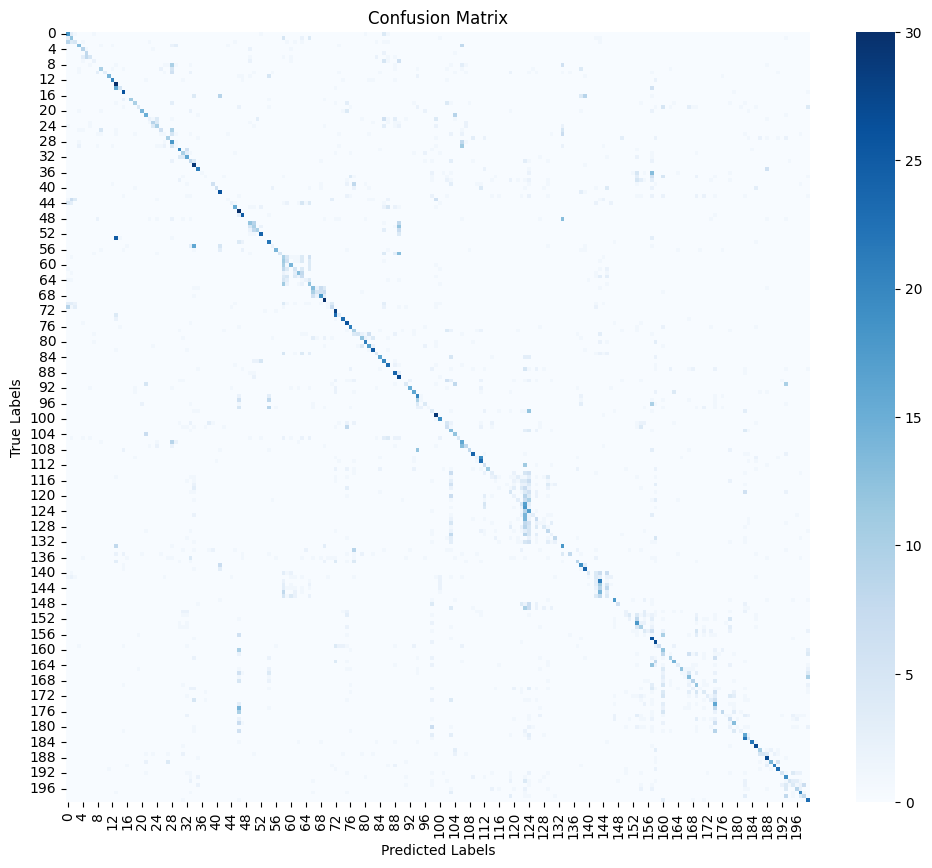

In [ ]:
# Step 5: Model Testing
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():  # Turn off gradient computation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="macro")  # Macro average
    rec = recall_score(all_labels, all_preds, average="macro")  # Macro average

    print(f"🎯 Accuracy: {acc:.4f}")
    print(f"🎯 Precision: {prec:.4f}")
    print(f"🎯 Recall: {rec:.4f}")

    # Plot the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, cmap="Blues", annot=False, fmt="d")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return acc, prec, rec

# Load the best model
model.load_state_dict(torch.load("best_resnet101.pth"))
acc, prec, rec = evaluate_model(model, dataloaders["test"])


In [ ]:
# Method 3 Load the EfficientNetV2-S pre-trained model

In [ ]:
# Step 1: Partition the dataset
import os
import shutil
import random
from zipfile import ZipFile
from tqdm import tqdm  # progress bar display

# **Step 1: Extract the dataset**
zip_path = "/content/drive/MyDrive/bird_CUB_200_2011.zip"  # Change to your actual path
extract_path = "/content/CUB_200_2011"

# Check if the dataset has already been extracted to avoid duplicate extraction
if not os.path.exists(extract_path):
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content")

# **Step 2: Set dataset directories**
data_root = extract_path  # Dataset root directory
images_dir = os.path.join(data_root, "images")  # Original images directory
train_dir = os.path.join(data_root, "train_images")  # Training images directory
test_dir = os.path.join(data_root, "test_images")  # Testing images directory

# Ensure the target directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# **Step 3: Read auxiliary dataset files**
def read_file(file_path):
    """Read the file and split it line by line"""
    with open(file_path, "r") as f:
        return [line.strip().split() for line in f.readlines()]

# Parse the files provided by the dataset
image_list = read_file(os.path.join(data_root, "images.txt"))  # List of image paths
image_labels = read_file(os.path.join(data_root, "image_class_labels.txt"))  # Mapping of image IDs to class labels
train_test_split = read_file(os.path.join(data_root, "train_test_split.txt"))  # Training/testing split information
classes = read_file(os.path.join(data_root, "classes.txt"))  # Mapping of class numbers to class names

# **Step 4: Construct class mappings**
class_map = {c[0]: c[1] for c in classes}  # {class number: class name}
image_class_map = {img[0]: img[1] for img in image_labels}  # {image ID: class label}
image_split_map = {split[0]: split[1] for split in train_test_split}  # {image ID: 0 (test) or 1 (train)}

# **Step 5: Organize the data**
print("📂 Organizing dataset...")

# Iterate over all images in the dataset
for img_id, img_path in tqdm(image_list, desc="Processing Images"):
    label_id = image_class_map[img_id]  # Get the class label
    split_flag = image_split_map[img_id]  # Get the train/test flag

    # Determine the target directory (training or testing)
    target_root = train_dir if split_flag == "1" else test_dir
    class_name = class_map[label_id]  # Get the class name
    target_class_dir = os.path.join(target_root, class_name)

    # Create the directory corresponding to the class
    os.makedirs(target_class_dir, exist_ok=True)

    # Build the source file path and the destination file path
    src_path = os.path.join(images_dir, img_path)  # Original file path
    dest_path = os.path.join(target_class_dir, os.path.basename(img_path))  # Destination file path

    # Move the file; if it fails, copy the file instead
    if os.path.exists(src_path):  # Ensure the file exists
        try:
            shutil.move(src_path, dest_path)  # Move the file directly
        except Exception as e:
            shutil.copy(src_path, dest_path)  # If moving fails, copy the file
            os.remove(src_path)  # Remove the original file

print("✅ Dataset organization completed!")

# **Step 6: Split the training set (9:1)**
print("📂 Splitting training set into training and validation subsets...")

# Set the target directories for the training and validation subsets
train_subset_dir = os.path.join(data_root, "train_subset")
val_subset_dir = os.path.join(data_root, "val_subset")

# Ensure the target directories exist
os.makedirs(train_subset_dir, exist_ok=True)
os.makedirs(val_subset_dir, exist_ok=True)

# Iterate over all classes in the training set
for class_name in tqdm(os.listdir(train_dir), desc="Splitting Train Set"):
    class_train_dir = os.path.join(train_dir, class_name)  # Original training set directory for the class
    class_train_subset_dir = os.path.join(train_subset_dir, class_name)  # Training subset directory for the class
    class_val_subset_dir = os.path.join(val_subset_dir, class_name)  # Validation subset directory for the class

    # Create the corresponding class directories for training and validation subsets
    os.makedirs(class_train_subset_dir, exist_ok=True)
    os.makedirs(class_val_subset_dir, exist_ok=True)

    # Get all image files for the class
    images = os.listdir(class_train_dir)
    if len(images) == 0:
        continue  # Skip to avoid errors from empty directories

    random.shuffle(images)  # Randomly shuffle images to avoid order bias

    # Calculate the 9:1 split index
    split_idx = int(len(images) * 0.9)
    train_images = images[:split_idx]
    val_images = images[split_idx:]

    # Move files to the corresponding subdirectories
    for img in train_images:
        shutil.move(os.path.join(class_train_dir, img), os.path.join(class_train_subset_dir, img))

    for img in val_images:
        shutil.move(os.path.join(class_train_dir, img), os.path.join(class_val_subset_dir, img))

print("✅ Training set has been split into training and validation subsets!")


📂 Organizing dataset...


Processing Images: 100%|██████████| 11788/11788 [00:00<00:00, 27029.70it/s]


✅ Dataset organization completed!
📂 Splitting training set into training and validation subsets...


Splitting Train Set: 100%|██████████| 200/200 [00:00<00:00, 1324.40it/s]

✅ Training set has been split into training and validation subsets!


In [ ]:
# Step 2: Load the dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data augmentation for the training set
# train_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),  # Random horizontal flip
#     transforms.RandomRotation(15),  # Rotation
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color perturbation
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),  # Random erasing
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Standard normalization for validation and test sets
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset paths
data_root = "/content/CUB_200_2011"
train_dir = os.path.join(data_root, "train_subset")
val_dir = os.path.join(data_root, "val_subset")
test_dir = os.path.join(data_root, "test_images")

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = ImageFolder(root=test_dir, transform=val_test_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Number of classes
num_classes = len(train_dataset.classes)
print(f"✅ Data loading completed! Total number of categories: {num_classes}")

# Load the pre-trained model

# Load the pre-trained EfficientNetV2-S model
model = models.efficientnet_v2_s(pretrained=True)

# Get the number of input features
in_features = model.classifier[1].in_features

# Replace the fully connected layer to adapt to 200-class classification
model.classifier[1] = nn.Linear(in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("✅ EfficientNetV2-S transfer learning model loaded!")


✅ Data loading completed! Total number of categories: 200
✅ EfficientNetV2-S transfer learning model loaded!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# **Define the CutMix random bounding box function**
def rand_bbox(size, lam):
    """Generate a random bounding box for CutMix"""
    W = size[2]  # Image width
    H = size[3]  # Image height
    cut_rat = np.sqrt(1. - lam)  # Calculate the crop ratio
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Randomly determine the center of the cropping area
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # Ensure the bounding box does not exceed the image boundaries
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def train_model(model, train_loader, val_loader, num_epochs=50, patience=10, lr=1e-4, weight_decay=1e-4, cutmix_prob=0.5):
    """
    Train the EfficientNetV2-S model using CutMix data augmentation.

    Parameters:
    - model: The model to be trained
    - train_loader: DataLoader for the training dataset
    - val_loader: DataLoader for the validation dataset
    - num_epochs: Number of training epochs (default 50)
    - patience: Patience for early stopping (default 10)
    - lr: Initial learning rate (default 1e-4)
    - weight_decay: Weight decay (default 1e-4)
    - cutmix_prob: Probability of applying CutMix (default 0.5)

    Returns:
    - The trained model
    """

    # Select device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define loss function & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

    # Early stopping parameters
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(1, num_epochs + 1):
        model.train()  # Set model to training mode
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Apply CutMix randomly
            if np.random.rand() < cutmix_prob:
                # Generate the mixing parameter lambda
                lam = np.random.beta(1.0, 1.0)
                rand_index = torch.randperm(images.size(0)).to(device)

                # Get the CutMix bounding box
                bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)

                # Generate CutMix images
                images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]

                # Generate CutMix labels
                labels_a, labels_b = labels, labels[rand_index]
                outputs = model(images)
                loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)

                # Modify accuracy calculation using CutMix weights
                _, predicted = outputs.max(1)
                correct_a = predicted.eq(labels_a).sum().item()
                correct_b = predicted.eq(labels_b).sum().item()
                correct += lam * correct_a + (1 - lam) * correct_b

            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()

            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size  # Accumulate batch loss weighted by batch size
            total += batch_size

        train_acc = correct / total
        avg_train_loss = running_loss / total  # Calculate epoch-level average loss
        scheduler.step()

        # Compute validation loss and accuracy
        model.eval()
        val_running_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                batch_size = images.size(0)
                val_running_loss += loss.item() * batch_size  # Accumulate batch loss
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += batch_size

        val_acc = val_correct / val_total
        avg_val_loss = val_running_loss / val_total  # Calculate epoch-level average validation loss

        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0  # Reset early stopping counter
            torch.save(model.state_dict(), "best_efficientnetv2s_cub200.pth")  # Save the best model
        else:
            patience_counter += 1

        # Print log every 5 epochs or at the first epoch or when improvement occurs
        if epoch % 5 == 0 or epoch == 1 or patience_counter == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Trigger early stopping if there is no improvement for consecutive 'patience' epochs
        if patience_counter >= patience:
            print(f"⏹ Early stopping trigger: No improvement in validation accuracy for {patience} consecutive epochs, stopping training!")
            break

    print("✅ Training finished!")
    return model


# Load the pre-trained EfficientNetV2-S model
model = models.efficientnet_v2_s(pretrained=True)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)  # Modify the classification layer

# Start training (with CutMix)
trained_model = train_model(model, train_loader, val_loader, num_epochs=50, patience=10, cutmix_prob=0.5)


Epoch [1/50] | Train Loss: 5.0286 | Train Acc: 0.0517 | Val Loss: 3.9429 | Val Acc: 0.2500
Epoch [2/50] | Train Loss: 3.7827 | Train Acc: 0.2415 | Val Loss: 2.4503 | Val Acc: 0.4767
Epoch [3/50] | Train Loss: 2.9590 | Train Acc: 0.4165 | Val Loss: 1.8074 | Val Acc: 0.6267
Epoch [4/50] | Train Loss: 2.4722 | Train Acc: 0.5145 | Val Loss: 1.4045 | Val Acc: 0.6667
Epoch [5/50] | Train Loss: 2.1596 | Train Acc: 0.5778 | Val Loss: 1.1389 | Val Acc: 0.7133
Epoch [6/50] | Train Loss: 1.8033 | Train Acc: 0.6656 | Val Loss: 1.0703 | Val Acc: 0.7383
Epoch [7/50] | Train Loss: 1.6622 | Train Acc: 0.6894 | Val Loss: 1.0017 | Val Acc: 0.7700
Epoch [9/50] | Train Loss: 1.7643 | Train Acc: 0.6700 | Val Loss: 0.9297 | Val Acc: 0.7767
Epoch [10/50] | Train Loss: 1.5106 | Train Acc: 0.7243 | Val Loss: 0.9280 | Val Acc: 0.7750
Epoch [14/50] | Train Loss: 1.5577 | Train Acc: 0.7165 | Val Loss: 0.8539 | Val Acc: 0.7800
Epoch [15/50] | Train Loss: 1.4571 | Train Acc: 0.7352 | Val Loss: 0.8823 | Val Acc: 0.7

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true, y_pred)

    return acc, precision, recall, f1, conf_matrix

# Calculate test set performance
test_acc, test_precision, test_recall, test_f1, test_conf_matrix = evaluate(model, test_loader)

print(f"✅ Test set results: Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")


✅ Test set results: Accuracy: 0.7989, Precision: 0.8106, Recall: 0.8004, F1: 0.7988


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate(model, dataloader, device):
    """
    Evaluate the model's performance on a given dataset, including:
    - Accuracy
    - Precision (Macro)
    - Recall (Macro)
    - F1-score (Macro)
    - Confusion Matrix (returned only, not plotted)

    Parameters:
    - model: Trained PyTorch model
    - dataloader: DataLoader for the evaluation dataset
    - device: Computing device (CPU/GPU)

    Returns:
    - acc: Accuracy
    - precision: Precision (Macro)
    - recall: Recall (Macro)
    - f1: F1-score (Macro)
    - conf_matrix: Confusion Matrix (returned only, not plotted)
    """

    model.eval()  # Set the model to evaluation mode
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)  # Get the class with the highest probability

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate evaluation metrics
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Print evaluation results
    print(f"✅ Test set results: Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return acc, precision, recall, f1, conf_matrix  # Return data only, without plotting

# Evaluate using the test set
test_acc, test_precision, test_recall, test_f1, test_conf_matrix = evaluate(model, test_loader, device)


✅ Test set results: Accuracy: 0.7989, Precision: 0.8106, Recall: 0.8004, F1: 0.7988


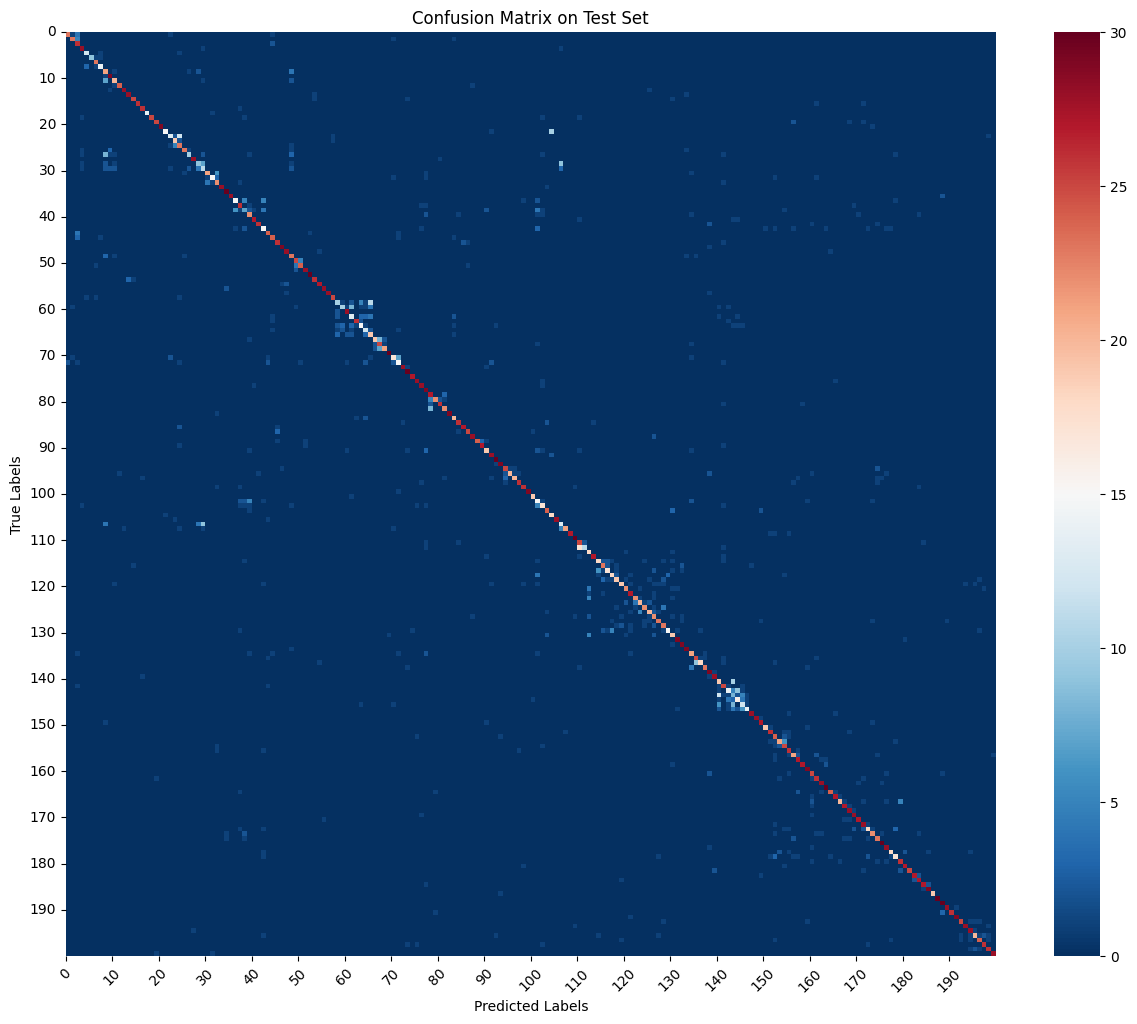

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, num_classes):
    """
    Plot a clear confusion matrix with optimized color contrast and without grid lines.

    Parameters:
    - conf_matrix: Confusion matrix (numpy array)
    - num_classes: Number of classes
    """
    plt.figure(figsize=(15, 12))  # Increase the canvas size

    # Disable grid lines and adjust the color contrast
    sns.heatmap(conf_matrix, cmap="RdBu_r", linewidths=0, vmin=0, vmax=conf_matrix.max())

    # Only display ticks for every 10 classes to avoid label overlap
    plt.xticks(ticks=np.arange(0, num_classes, step=10), labels=np.arange(0, num_classes, step=10), rotation=45)
    plt.yticks(ticks=np.arange(0, num_classes, step=10), labels=np.arange(0, num_classes, step=10), rotation=0)

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix on Test Set")
    plt.show()

# Re-plot the optimized confusion matrix
plot_confusion_matrix(test_conf_matrix, num_classes=200)


In [ ]:
torch.save(model.state_dict(), "efficientnetv2s_cub200.pth")
print("✅ Model saved!")

✅ Model saved!
